<a href="https://colab.research.google.com/github/warwavn/AIMLKMITL2024/blob/Day3/Day3/Excercise/ex_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

# Run the installation commands
!pip install opendatasets
!pip install kaggle
!pip install faiss-gpu
!pip install transformers datasets
# Clean up the notebook
clean_notebook()

Notebook cleaned.


# https://www.kaggle.com/datasets/vkehfdl1/kidf-kpop-idol-dataset-female

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/vkehfdl1/kidf-kpop-idol-dataset-female")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: teerakarnm
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/vkehfdl1/kidf-kpop-idol-dataset-female


100%|██████████| 1.03G/1.03G [00:09<00:00, 120MB/s]


# Understanding the Data

In [3]:
import pandas as pd

# Read the CSV files
train_labels = pd.read_csv('/content/kidf-kpop-idol-dataset-female/kid_f_train.csv')
test_labels = pd.read_csv('/content/kidf-kpop-idol-dataset-female/kid_f_test.csv')

# Concatenate the DataFrames
all_labels = pd.concat([train_labels, test_labels], ignore_index=True)

# Display the concatenated DataFrame
all_labels




,file_name,name
0,5.jpg,yujin
1,8.jpg,yujin
2,17.jpg,yujin
3,23.jpg,yujin
4,26.jpg,yujin
...,...,...
5886,85363.jpg,jisoo
5887,85387.jpg,jisoo
5888,85451.jpg,jisoo
5889,85458.jpg,jisoo


In [20]:
import pandas as pd

# Read the CSV files
train_labels = pd.read_csv('/content/kidf-kpop-idol-dataset-female/kid_f_train.csv')
test_labels = pd.read_csv('/content/kidf-kpop-idol-dataset-female/kid_f_test.csv')

# Concatenate the DataFrames
all_labels = pd.concat([train_labels, test_labels], ignore_index=True)

# Display the concatenated DataFrame
all_labels



,file_name,name
0,5.jpg,yujin
1,8.jpg,yujin
2,17.jpg,yujin
3,23.jpg,yujin
4,26.jpg,yujin
...,...,...
5886,85363.jpg,jisoo
5887,85387.jpg,jisoo
5888,85451.jpg,jisoo
5889,85458.jpg,jisoo


In [21]:

all_labels['name'].value_counts()

name
lisa                  1322
rose                  1287
jisoo                 1095
jennie                 429
kimminju               271
joyuri                 265
choiyena               142
kimchaewon             122
hondahitomi            121
kanghyewon              86
nayeon                  81
sakura                  81
oliviahye               75
kwoneunbi               70
iu                      64
yujin                   59
wonyoung                53
hongeunchae             36
ningning                28
karina                  26
giselle                 25
winter                  25
huhyunjin               22
kazuha                  21
bravegirls_yuna         19
minyoung                11
bravegirls_eunji         7
bravegirls_yujeong       7
hani                     6
jihyo                    3
momo                     2
hyerin                   2
chaewon                  2
hyuna                    2
seeun                    2
sola                     1
hwasa                  

In [24]:
import os
from datasets import load_dataset

# Function to get file paths
def get_file_paths(examples):
    examples['file'] = [os.path.basename(example.filename) for example in examples['image']]
    return examples


# Function to get file labels
def get_label(examples):
    examples['label'] = []
    for example in examples['file']:

        results = all_labels[all_labels["file_name"] == example]
        if len(results) == 1:
            examples['label'].append(results.iloc[0]["name"])
        else :
             examples['label'].append("No name")

    return examples


dataset = load_dataset("imagefolder", data_dir="/content/kidf-kpop-idol-dataset-female/HQ_512x512")
dataset = dataset.map(get_file_paths, batched=True, batch_size=8, num_proc=os.cpu_count())
dataset = dataset.map(get_label, batched=True, batch_size=2, num_proc=os.cpu_count())
dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)
dataset =dataset.remove_columns('file')

Resolving data files:   0%|          | 0/5592 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map (num_proc=2):   0%|          | 0/5591 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/5591 [00:00<?, ? examples/s]

In [22]:
###
import os
from datasets import load_dataset

# dataset = all_labels


In [25]:
# Print the dataset to verify
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4472
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1119
    })
})

In [32]:
# Shuffle and select 1200 random samples from the training dataset
dataset = dataset['train'].shuffle(seed=42).select(range(500))
#Split the train dataset
dataset = dataset.train_test_split(test_size=0.2, seed=42)

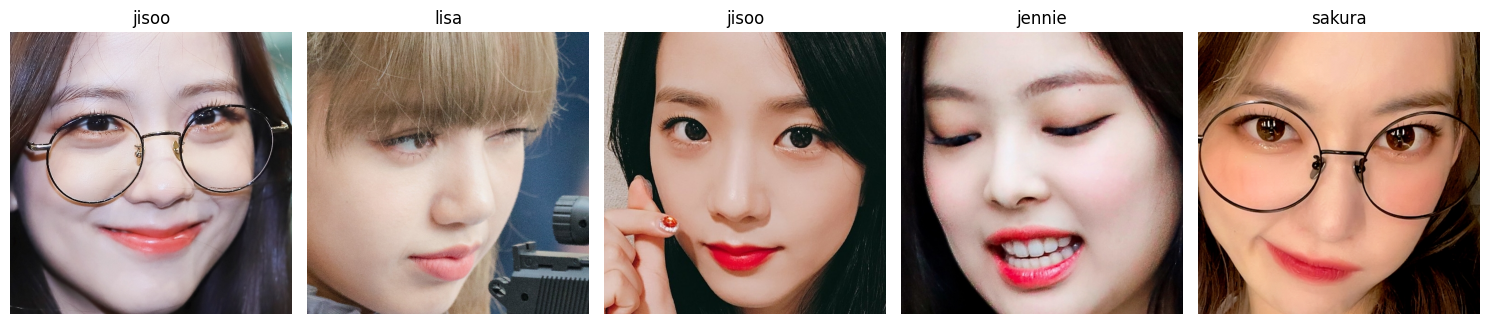

In [33]:
# Import necessary libraries
import matplotlib.pyplot as plt
from datasets import load_dataset
import random


# Select 5 random indices
random_indices = random.sample(range(len(dataset['train'])), 5)

# Display the randomly selected images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image = dataset['train'][idx]['image']
    label = dataset['train'][idx]['label']
    axes[i].imshow(image)
    axes[i].set_title(f"{label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [29]:
# Load the CLIP model
import os
import faiss
import torch
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [34]:
# Function to preprocess images in batches
def preprocess_images_batch(images):
    return processor(images=images, return_tensors="pt").to(device)

# Function to get image embeddings in batches with normalization
def get_image_embeddings_batch(images):
    with torch.no_grad():
        inputs = preprocess_images_batch(images)
        image_features = model.get_image_features(**inputs)
    # Convert to numpy array
    image_features_np = image_features.cpu().numpy()
    # Normalize embeddings
    norms = np.linalg.norm(image_features_np, axis=1, keepdims=True)
    normalized_embeddings = image_features_np / norms
    return normalized_embeddings

In [35]:
from tqdm import tqdm
# Process images in batches
batch_size = 32 # You can adjust this based on your GPU memory
image_embeddings = []

for i in tqdm(range(0, len(dataset['train']['image']), batch_size), desc="Generating embeddings"):
    batch_images = dataset['train']['image'][i:i + batch_size]
    batch_embeddings = get_image_embeddings_batch(batch_images)
    image_embeddings.append(batch_embeddings)

Generating embeddings: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


In [36]:
image_embeddings = np.vstack(image_embeddings)
image_embeddings.shape

(400, 512)

In [37]:
# Create and populate the Faiss index
d = image_embeddings.shape[1]  # Dimension of the embeddings
print("d = ",d)

index = faiss.IndexFlatL2(d)
index.add(image_embeddings)

d =  512


In [38]:
# Perform a search
def search_image(query_image, k=5):
    query_embedding = get_image_embeddings_batch(query_image)
    distances, indices = index.search(query_embedding, k)
    return distances[0], indices[0]

idx        = 7
query_image = dataset['test'][idx]['image']
distances, top_k_indices = search_image(query_image)

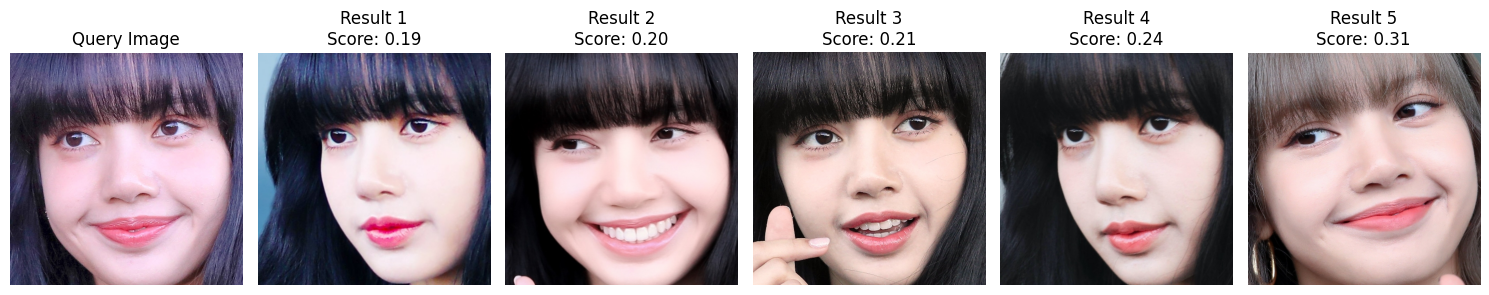

In [39]:
# Display the query image and search results
fig, axes = plt.subplots(1, len(top_k_indices) + 1, figsize=(15, 5))

# Display the query image
axes[0].imshow(query_image)
axes[0].set_title("Query Image")
axes[0].axis('off')

# Display the search results
for i, idx in enumerate(top_k_indices):
    result_image = dataset['train']['image'][idx]
    axes[i + 1].imshow(result_image)
    axes[i + 1].set_title(f"Result {i+1}\nScore: {distances[i]:.2f}")
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()